In [1]:
import os

os.chdir("/workspaces/example_digital-twin_incubator_twright/software/incubator")

In [2]:
import sys

sys.path.append("/workspaces/example_digital-twin_incubator_twright/software")

In [3]:
import matplotlib.pyplot as plt

In [4]:
from digital_twin.simulator.verified_plant_simulator import VerifiedPlantMonitor4Params

In [5]:
from verified_twin.lbuc import *
import sage.all as sg
from sage.all import RIF

In [6]:
sg.var("T_A", "T_H")

(T_A, T_H)

In [7]:
plt.rcParams['figure.figsize'] = [60/2.54, 30/2.54]

In [8]:
from incubator.tests.self_adaptation_tests.test_self_adaptation import *

/home/sage/sage/local/lib/python3.9/site-packages/control/xferfcn.py:1498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(data[i][j][k], (int, np.int)):


In [9]:
import numpy as np
from oomodelling import Model

from incubator.calibration.calibrator import Calibrator
from incubator.self_adaptation.controller_optimizer import IControllerOptimizer
from incubator.interfaces.updateable_kalman_filter import IUpdateableKalmanFilter

In [10]:
properties = [
    Atomic(T_A < RIF(35)),
]

## Self-Adaptation Loop Integration

In [11]:
config = load_config("startup.conf")

n_samples_period = config["physical_twin"]["controller_open_loop"]["n_samples_period"]
n_samples_heating = 5
C_air = config["digital_twin"]["models"]["plant"]["param4"]["C_air"]
G_box = config["digital_twin"]["models"]["plant"]["param4"]["G_box"]
G_box_kf = G_box
C_heater = config["digital_twin"]["models"]["plant"]["param4"]["C_heater"]
G_heater = config["digital_twin"]["models"]["plant"]["param4"]["G_heater"]
initial_box_temperature = 41
initial_heat_temperature = 47
initial_room_temperature = 21  # TODO: Add this parameter to config file.
std_dev = 0.001
step_size = 3.0
anomaly_threshold = 2.0
# Time spent before declaring that there is an self_adaptation_manager, after the first time the self_adaptation_manager occurred.
ensure_anomaly_timer = 1
# Time spent, after the self_adaptation_manager was declared as detected, just so enough data about the system is gathered.
# The data used for recalibration will be in interval [time_first_occurrence, time_data_gathered]
gather_data_timer = 10
cool_down_timer = 5
optimize_controller = True

conv_xatol = 0.1
conv_fatol = 0.1
max_iterations = 200
desired_temperature = 41
max_t_heater = 60
restrict_T_heater = True

# Supervisor parameters
trigger_optimization_threshold = 10.0
heater_underused_threshold = 10.0
wait_til_supervising_timer = 100  # N steps supervisor should wait before kicking in.

tf = 6000

kalman = KalmanFilter4P(step_size, std_dev,
                        C_air, G_box_kf, C_heater, G_heater,
                        initial_room_temperature, initial_heat_temperature, initial_box_temperature)

database = MockDatabase(step_size)
plant_simulator = PlantSimulator4Params()
calibrator = Calibrator(database, plant_simulator, conv_xatol, conv_fatol, max_iterations)
pt_simulator = SystemModel4ParametersOpenLoopSimulator()
ctrl = MockController()

verified_monitor = VerifiedPlantMonitor4Params(properties)

if optimize_controller:
    ctrl_optimizer = ControllerOptimizer(database, pt_simulator, ctrl, conv_xatol, conv_fatol, max_iterations, restrict_T_heater, desired_temperature, max_t_heater)
else:
    ctrl_optimizer = NoOPControllerOptimizer()

anomaly_detector = SelfAdaptationManager(anomaly_threshold, ensure_anomaly_timer, gather_data_timer, cool_down_timer,
                                         calibrator, kalman, ctrl_optimizer,
                                         verified_monitor,
                                         lookahead_time=500.0)
# supervisor = SupervisorPeriodicSM(ctrl_optimizer, wait_til_supervising_timer)
supervisor = SupervisorThresholdSM(ctrl_optimizer, desired_temperature, max_t_heater,
                                   trigger_optimization_threshold, heater_underused_threshold,
                                   wait_til_supervising_timer)

m = SelfAdaptationScenario(n_samples_period, n_samples_heating,
                           C_air, G_box, C_heater, G_heater,
                           initial_box_temperature,
                           initial_heat_temperature,
                           initial_room_temperature,
                           kalman, anomaly_detector, supervisor,
                           std_dev)

# Inform mock db of plant _plant.
database.set_models(m.physical_twin.plant, m.physical_twin.ctrl)
# Inform mock of controller
ctrl.set_model(m.physical_twin.ctrl)

# Wire in a custom function for the G_box input, so we can change it.
m.physical_twin.plant.G_box = lambda: G_box if m.time() < 1000 else (G_box * 10 if m.time() < 2000 else G_box)

# Wire in a custom function for the C_air parameter,
# so we mimick a different object being placed in the incubator.
# Commented out because it does not seem to work very well.
# m.physical_twin.plant.C_air = lambda: C_air if m.time() < 1000 else (C_air * 7 if m.time() < 2000 else C_air)

ModelSolver().simulate(m, 0.0, tf, 3.0)

/home/sage/sage/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


running verified monitoring for anomaly between times 1002.5938409201124 and 1035.5938409201124
x = [1002.5938409201124?, 118.89228178690598, 81.23814632391037]
state = {'heater_on': False, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1017.59384092?, 112.527264?, 54.42682?]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1032.59384092?, 104.88858?, 43.95630?]
state = {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1047.59384092?, 105.10438?, 39.84384?]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1062.59384092?, 97.21012?, 37.79207?]
state = {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 12026
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
       5.99459384e+03, 5.99759384e+03, 6.00000000e+03])
 t_events: None
        y: array([[0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       ...,
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.994

In [12]:
m.self_adaptation_manager.state_machine.anomaly_durations

[(1002.5938409201124, 1035.5938409201124),
 (1068.5938409201124, 1101.5938409201124),
 (2010.5938409201124, 2043.5938409201124)]

In [13]:
m.self_adaptation_manager.state_machine.anomaly_parameters

[(1002.5938409201124,
  1502.5938409201124,
  81.23814632391037,
  118.89228178690598,
  21,
  3.0,
  10,
  5,
  141.71945977643318,
  7.8338353184845495,
  227.76228512,
  1.92343277),
 (1068.5938409201124,
  1568.5938409201124,
  38.48557931545541,
  103.27713248422768,
  21,
  3.0,
  10,
  5,
  272.01832249938576,
  8.315644265351954,
  227.76228512,
  1.92343277),
 (2010.5938409201124,
  2510.5938409201126,
  32.607154528547476,
  59.77326802388883,
  21,
  3.0,
  10,
  0,
  102.28707795820601,
  1.412942235649828,
  227.76228512,
  1.92343277)]

In [14]:
m.self_adaptation_manager.state_machine.verified_monitoring_results

[[Signal([1002.5938409201123 .. 1502.5938409201124], [([1002.5938409201123 .. 1113.5219342050635], False), ([1113.5219843513029 .. 1502.5938409201124], True)], mask=None)],
 [Signal([1068.5938409201123 .. 1568.5938409201124], [([1068.5938409201123 .. 1114.6680420559520], False), ([1114.6680508244801 .. 1568.5938409201124], True)], mask=None)],
 [Signal([2010.5938409201123 .. 2510.5938409201126], [([2010.5938409201123 .. 2018.7794201622776], True), ([2018.7794201622812 .. 2166.8100448029950], False), ([2166.8100448034010 .. 2510.5938409201126], True)], mask=None)]]

### Manually apply uncertainty calibration for 3rd Anomaly

In [15]:
m.self_adaptation_manager.state_machine.anomaly_parameters[2]

(2010.5938409201124,
 2510.5938409201126,
 32.607154528547476,
 59.77326802388883,
 21,
 3.0,
 10,
 0,
 102.28707795820601,
 1.412942235649828,
 227.76228512,
 1.92343277)

In [16]:
verified_trace3, verified_model3 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[2])
verified_sigs3 = m.self_adaptation_manager.state_machine.verified_monitoring_results[2]

x = [2010.5938409201124?, 59.77326802388883, 32.607154528547476]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [500.00000000000022 .. 500.00000000000023] ...
ran verified simulation in 4.7864744663238525 sec


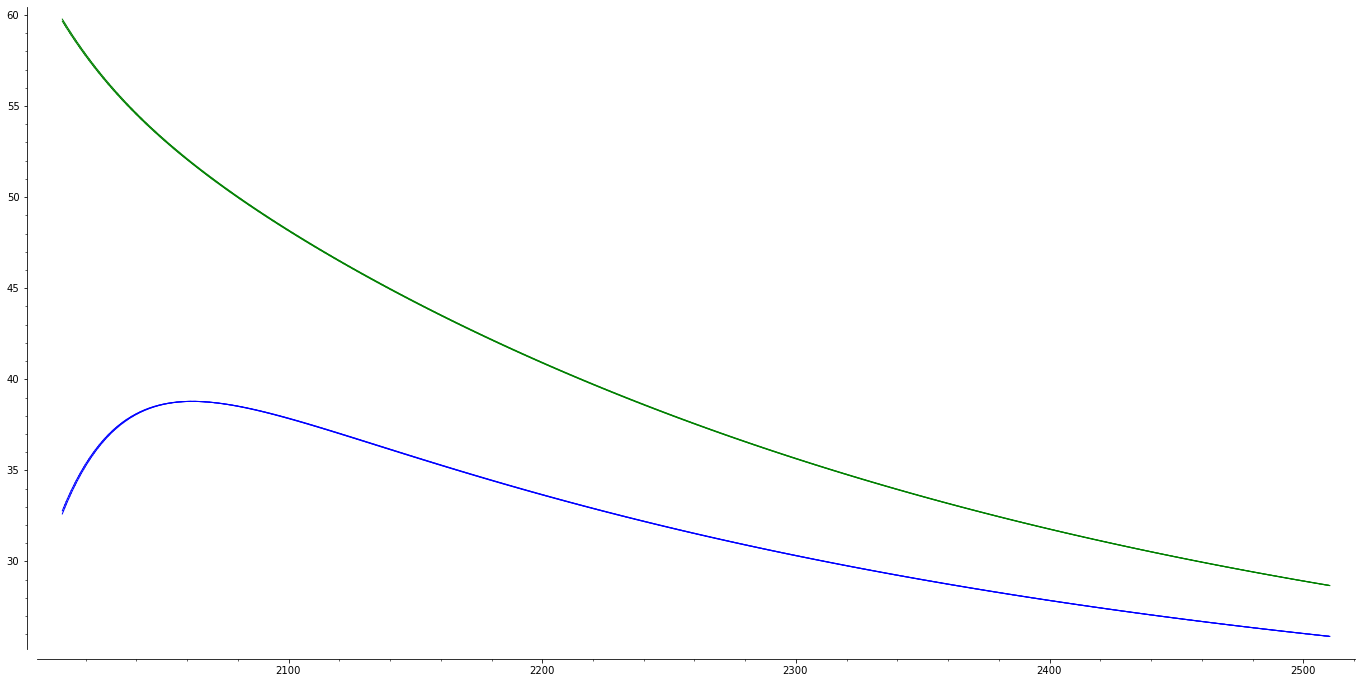

In [17]:
p = verified_trace3.plot(('T_A', 'T_H'), color=('blue', 'green')); p.matplotlib()

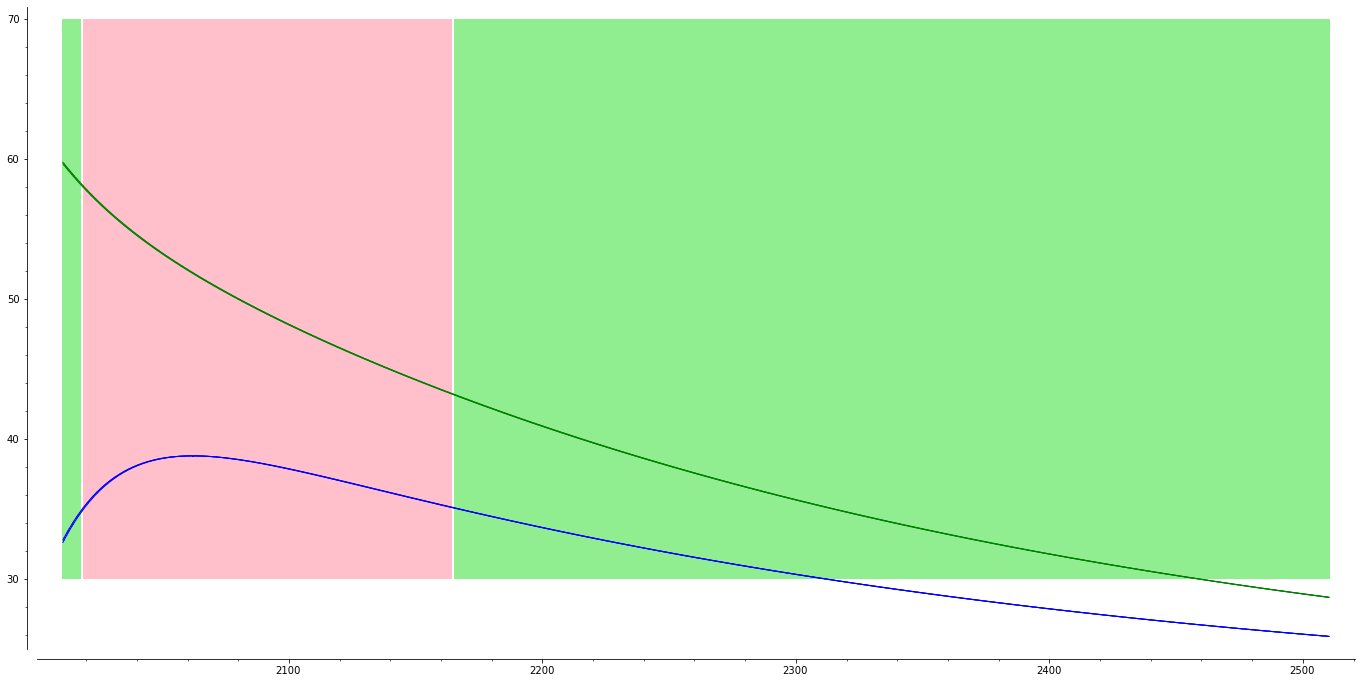

In [18]:
p1 = (verified_sigs3[0].plot(y_range=(30, 70)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

In [19]:
tstart, tend = m.self_adaptation_manager.state_machine.anomaly_durations[2]

In [20]:
 success, C_air, G_box, C_heater, G_heater = calibrator.calibrate(tstart, tend)

In [21]:
m.self_adaptation_manager.state_machine.kalman_filter.update_parameters(C_air, G_box, C_heater, G_heater)

In [22]:
C_air, G_box, C_heater, G_heater

(98.40107990423923, 1.5142531931818604, 227.76228512, 1.92343277)

In [23]:
signals, t_start_idx, t_end_idx = calibrator.database.get_plant_signals_between(tstart, tend)
times = signals["time"][t_start_idx:t_end_idx]
reference_T = signals["T"][t_start_idx:t_end_idx]
ctrl_signal = signals["in_heater_on"][t_start_idx:t_end_idx]
reference_T_heater = signals["T_heater"][t_start_idx:t_end_idx]
room_T = signals["in_room_temperature"][t_start_idx:t_end_idx]

In [24]:
sol, model = calibrator.plant_simulator.run_simulation(
    times, reference_T[0], reference_T_heater[0], room_T, ctrl_signal,
    C_air, G_box, C_heater, G_heater)

In [25]:
from digital_twin.calibration.uncertainty_calibrator import *

In [26]:
system = UncertaintyCalibrationSystem(times,
    reference_T[0], reference_T_heater[0],
    C_air, G_box, C_heater, G_heater,
    room_T, ctrl_signal)

In [27]:
prob = UncertaintyCalibrationProblem(sol, system)

In [28]:
from verified_twin.traces import NumericalContinuousTrace

In [29]:
sol.y

array([[2010.59384092, 2013.59384092, 2016.59384092, 2019.59384092,
        2022.59384092, 2025.59384092, 2028.59384092, 2031.59384092,
        2034.59384092, 2037.59384092, 2040.59384092],
       [  32.60715453,   33.59174142,   34.49957249,   35.37263024,
          36.21420062,   37.02720313,   37.81423242,   38.51931425,
          39.1191447 ,   39.62590966,   40.05041005],
       [  59.77326802,   59.30295582,   60.30220521,   61.29872359,
          62.29175144,   63.28062578,   64.04848178,   63.40128214,
          62.78656283,   62.20103441,   61.64177686]])

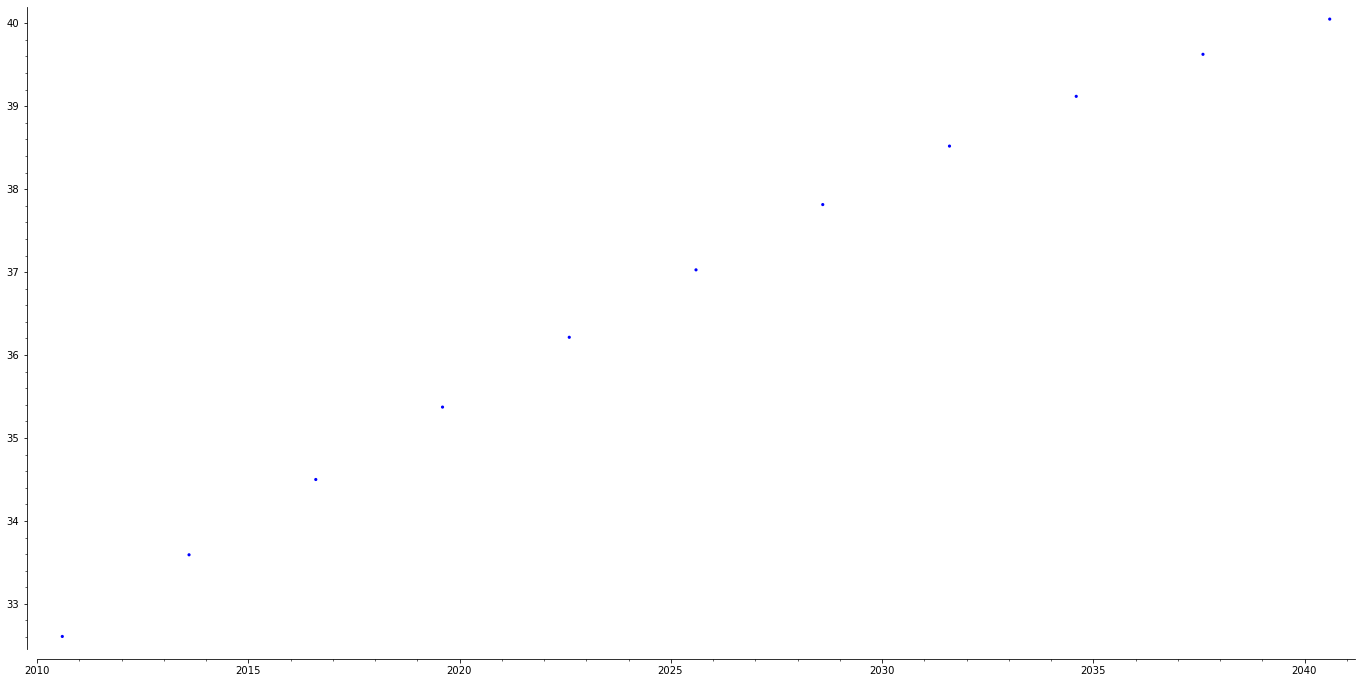

In [30]:
sg.points(zip(sol.y[0], sol.y[1])).matplotlib()

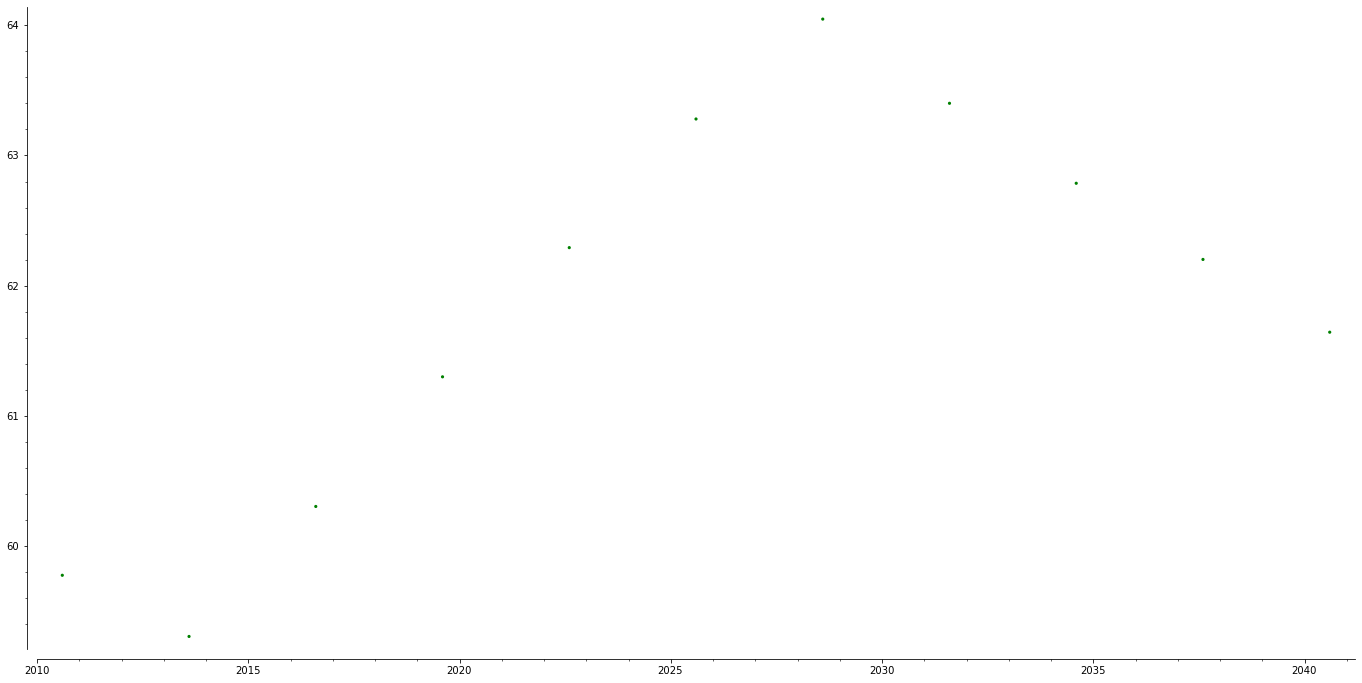

In [31]:
sg.points(zip(sol.y[0], sol.y[2]), color='green').matplotlib()

In [32]:
verified_trace3b, verified_model3b = VerifiedPlantMonitor4Params.run_simulation(tstart, tend, *m.self_adaptation_manager.state_machine.anomaly_parameters[2][2:])

x = [2010.5938409201124?, 59.77326802388883, 32.607154528547476]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [33.000000000000000 .. 33.000000000000000] ...
ran verified simulation in 0.28463244438171387 sec


In [33]:
from verified_twin.incubator_models import *


In [34]:
verified_trace3c = system.verified_trace(2**-2, 2**-2, 2**-2, 2**-2)

x = [2010.5938409201124?, 60.?, 33.?, 99.?, 2.?]
state = {'heater_on': False}
regenerating model with x=['[2010.5938409201123 .. 2010.5938409201124]', '[59.523268023888824 .. 60.023268023888840]', '[32.357154528547468 .. 32.857154528547483]', '[98.151079904239210 .. 98.651079904239240]', '[1.2642531931818601 .. 1.7642531931818606]']
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [2013.593840920?, 59.?, 34.?, 99.?, 2.?]
state = {'heater_on': True}
regenerating model with x=['[2013.5938409199397 .. 2013.5938409203473]', '[58.855254952309579 .. 59.357406605851353]', '[33.259922922710032 .. 33.923567019327117]', '[98.151079904239168 .. 98.651079904239282]', '[1.2642531931818268 .. 1.7642531931818939]']
running for [14.999999999765122 .. 15.000000000172577] ...
x = [2028.59384092?, 64.?, 38.?, 99.?, 2.?]
state = {'heater_on': False}
regenerating model with x=['[2028.5938409188379 .. 2028.5938409215265]', '[63.803709752605151 .. 64.373691944912580]', '[37.045396820177955 .. 3

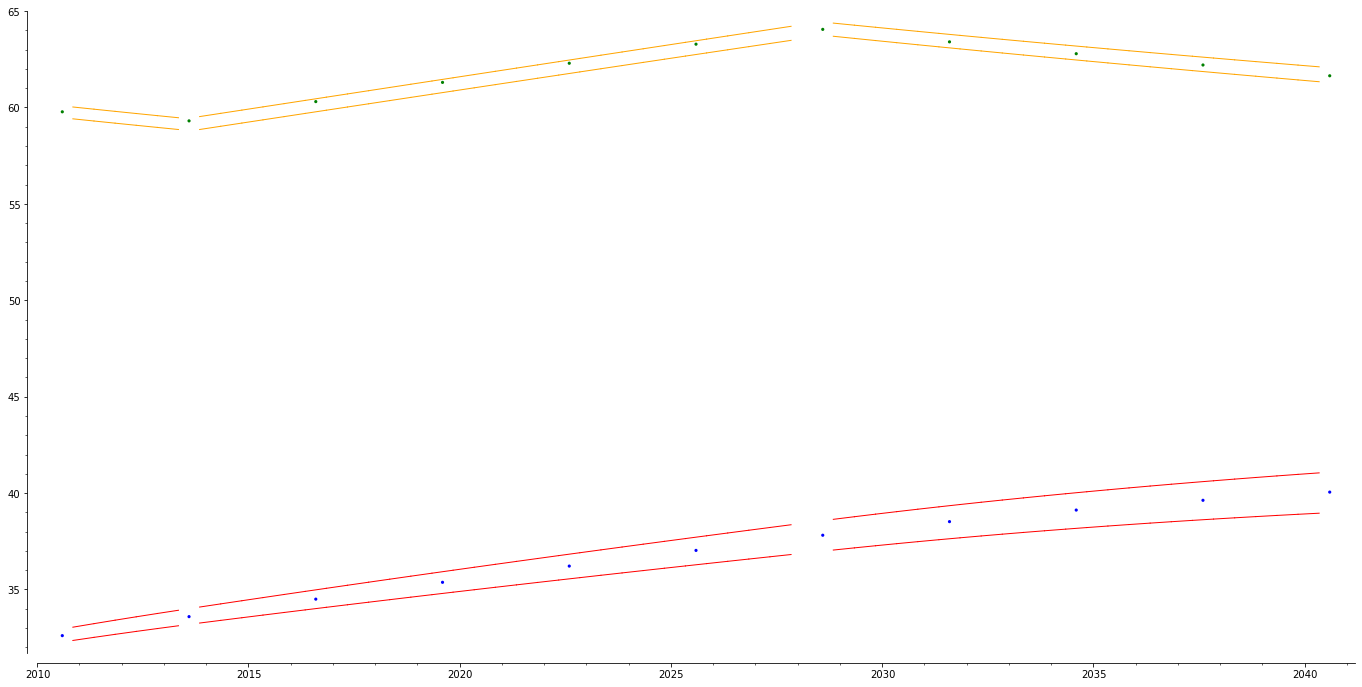

In [35]:
(  sg.points(zip(sol.y[0], sol.y[1]))
 + sg.points(zip(sol.y[0], sol.y[2]), color='green')
 + verified_trace3c.plot(('T_A', 'T_H'), color=('red', 'orange'))
).matplotlib()

In [36]:
verified_trace3d = system.verified_trace(-2**1, -2**1, 2**-1, 2**-1)

x = [2010.5938409201124?, 6.?e1, 4.?e1, 98.?, 2.?]
state = {'heater_on': False}
regenerating model with x=['[2010.5938409201123 .. 2010.5938409201124]', '[57.773268023888832 .. 61.773268023888833]', '[30.607154528547475 .. 34.607154528547476]', '[97.901079904239210 .. 98.901079904239240]', '[1.0142531931818601 .. 2.0142531931818609]']
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [2013.593840920?, 6.?e1, 4.?e1, 98.?, 2.?]
state = {'heater_on': True}
regenerating model with x=['[2013.5938409199397 .. 2013.5938409203473]', '[57.104402481269964 .. 61.108259472017779]', '[31.465166660755500 .. 35.718353745454408]', '[97.901079904239139 .. 98.901079904239311]', '[1.0142531931817932 .. 2.0142531931819275]']
running for [14.999999999765122 .. 15.000000000172577] ...
x = [2028.59384092?, 7.?e1, 4.?e1, 98.?, 2.?]
state = {'heater_on': False}
regenerating model with x=['[2028.5938409188379 .. 2028.5938409215265]', '[62.031869041441467 .. 66.145543810817643]', '[34.98681547483536

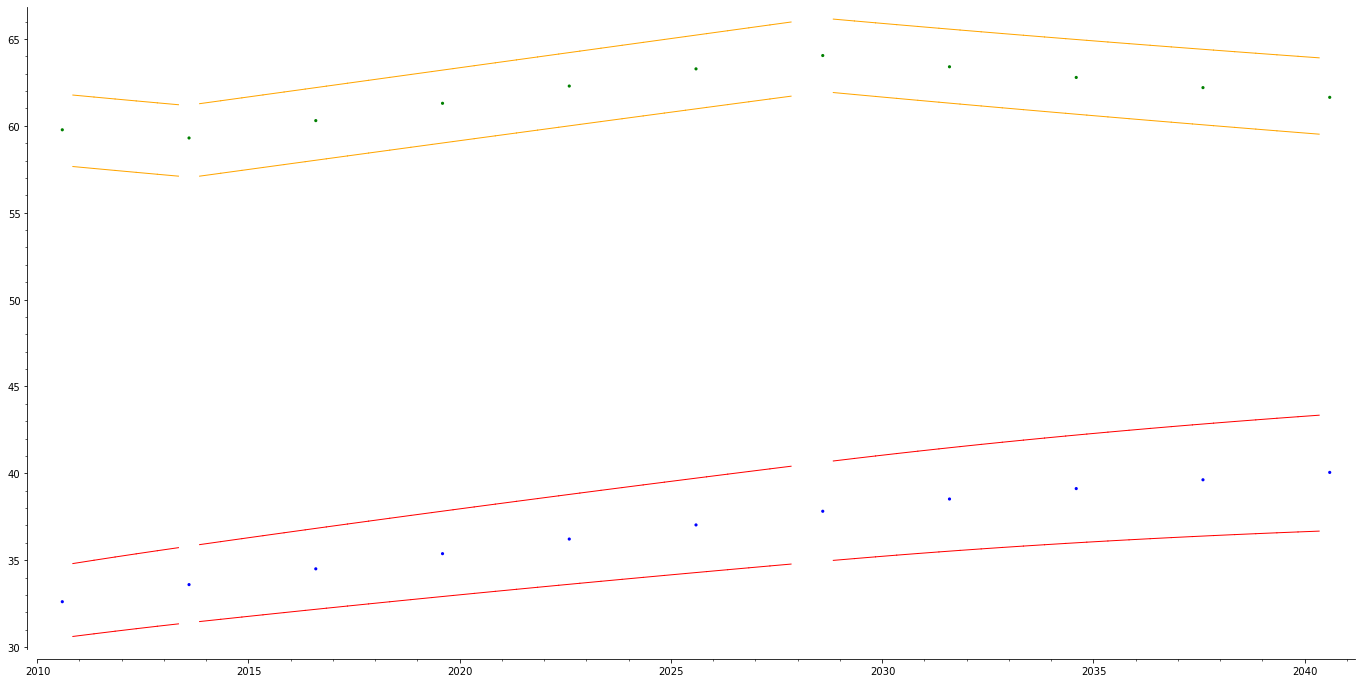

In [37]:
(  sg.points(zip(sol.y[0], sol.y[1]))
 + sg.points(zip(sol.y[0], sol.y[2]), color='green')
 + verified_trace3d.plot(('T_A', 'T_H'), color=('red', 'orange'))
).matplotlib()

In [38]:
params = prob.solution_raw(method='Nelder-Mead',
            options={'maxiter': 10, 'xatol': 0.1, 'fatol': 1}); params

x = [2010.5938409201124?, 6.?e1, 4.?e1, 1.0?e2, 1.?e1]
state = {'heater_on': False}
regenerating model with x=['[2010.5938409201123 .. 2010.5938409201124]', '[58.773268023888832 .. 60.773268023888833]', '[31.607154528547475 .. 33.607154528547476]', '[97.401079904239225 .. 99.401079904239226]', '[0.51425319318186035 .. 2.5142531931818604]']
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [2013.593840920?, 6.?e1, 4.?e1, 1.0?e2, 1.?e1]
state = {'heater_on': True}
regenerating model with x=['[2013.5938409199397 .. 2013.5938409203473]', '[58.101659777692326 .. 60.111003697158794]', '[32.234309769774903 .. 34.949328501163223]', '[97.401079904239225 .. 99.401079904239226]', '[0.51425319318186035 .. 2.5142531931818604]']
running for [14.999999999765122 .. 15.000000000172577] ...
x = [2028.59384092?, 7.?e1, 4.?e1, 1.0?e2, 1.?e1]
state = {'heater_on': False}
regenerating model with x=['[2028.5938409188379 .. 2028.5938409215265]', '[62.932140143918786 .. 65.245317828007942]', '[34.

 final_simplex: (array([[1.04714966, 1.21304321, 1.10977173, 0.2934082 ],
       [1.09446106, 1.21769104, 1.16283264, 0.29543457],
       [1.0822998 , 1.19138184, 1.04665527, 0.52480469],
       [1.01230469, 1.09433594, 1.11777344, 0.7046875 ],
       [1.06123047, 1.04443359, 1.07177734, 0.73046875]]), array([5707.50905066, 5715.16105904, 5797.27293181, 5854.47233526,
       5868.10200601]))
           fun: 5707.509050663619
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 19
           nit: 10
        status: 2
       success: False
             x: array([1.04714966, 1.21304321, 1.10977173, 0.2934082 ])

In [39]:
verified_trace3e = system.verified_trace(*params.x)

x = [2010.5938409201124?, 6.?e1, 4.?e1, 1.0?e2, 2.?]
state = {'heater_on': False}
regenerating model with x=['[2010.5938409201123 .. 2010.5938409201124]', '[58.726118365685707 .. 60.820417682091958]', '[31.394111315656854 .. 33.820197741438101]', '[97.291308175723600 .. 99.510851632754851]', '[1.2208449900568636 .. 1.8076613963068571]']
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [2013.593840920?, 6.?e1, 4.?e1, 1.0?e2, 2.?]
state = {'heater_on': True}
regenerating model with x=['[2013.5938409199397 .. 2013.5938409203473]', '[58.054021593776568 .. 60.158641965687366]', '[32.312663182562175 .. 34.870980277054273]', '[97.291308175723457 .. 99.510851632754993]', '[1.2208449900568303 .. 1.8076613963068904]']
running for [14.999999999765122 .. 15.000000000172577] ...
x = [2028.59384092?, 7.?e1, 4.?e1, 1.0?e2, 2.?]
state = {'heater_on': False}
regenerating model with x=['[2028.5938409188379 .. 2028.5938409215265]', '[62.988331326737927 .. 65.189125075640462]', '[36.14514145

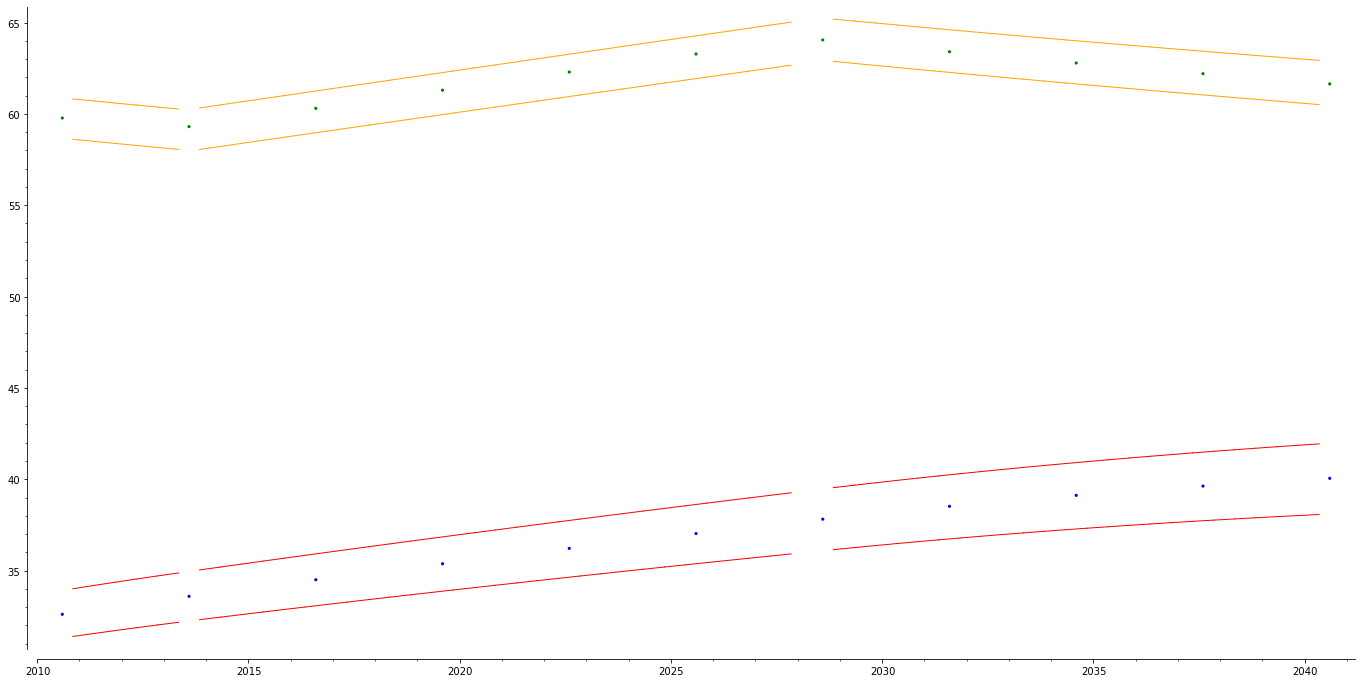

In [40]:
(  sg.points(zip(sol.y[0], sol.y[1]))
 + sg.points(zip(sol.y[0], sol.y[2]), color='green')
 + verified_trace3e.plot(('T_A', 'T_H'), color=('red', 'orange'))
).matplotlib()

In [41]:
uncertainty_calibrator = UncertaintyCalibrator(database, calibrator.plant_simulator, 1, 1, 1)

In [42]:
uncertainty_calibrator.executor = executor

NameError: name 'executor' is not defined

In [43]:
uncertainty_calibrator.calibrate(tstart, tend, C_air, G_box, C_heater, G_heater)

x = [2010.5938409201124?, 6.?e1, 4.?e1, 1.0?e2, 1.?e1]
state = {'heater_on': False}
regenerating model with x=['[2010.5938409201123 .. 2010.5938409201124]', '[58.773268023888832 .. 60.773268023888833]', '[31.607154528547475 .. 33.607154528547476]', '[97.401079904239225 .. 99.401079904239226]', '[0.51425319318186035 .. 2.5142531931818604]']
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [2013.593840920?, 6.?e1, 4.?e1, 1.0?e2, 1.?e1]
state = {'heater_on': True}
regenerating model with x=['[2013.5938409199397 .. 2013.5938409203473]', '[58.101659777692326 .. 60.111003697158794]', '[32.234309769774903 .. 34.949328501163223]', '[97.401079904239225 .. 99.401079904239226]', '[0.51425319318186035 .. 2.5142531931818604]']
running for [14.999999999765122 .. 15.000000000172577] ...
x = [2028.59384092?, 7.?e1, 4.?e1, 1.0?e2, 1.?e1]
state = {'heater_on': False}
regenerating model with x=['[2028.5938409188379 .. 2028.5938409215265]', '[62.932140143918786 .. 65.245317828007942]', '[34.

(6.?e1, 4.?e1, 1.0?e2, 2.?)